## 0. Intro

The aim of this notebook is to get familiar with **classification problems** and **logistic regression**.  

We will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

from sklearn import model_selection
from sklearn import datasets

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from IPython import display

import typing
%matplotlib inline

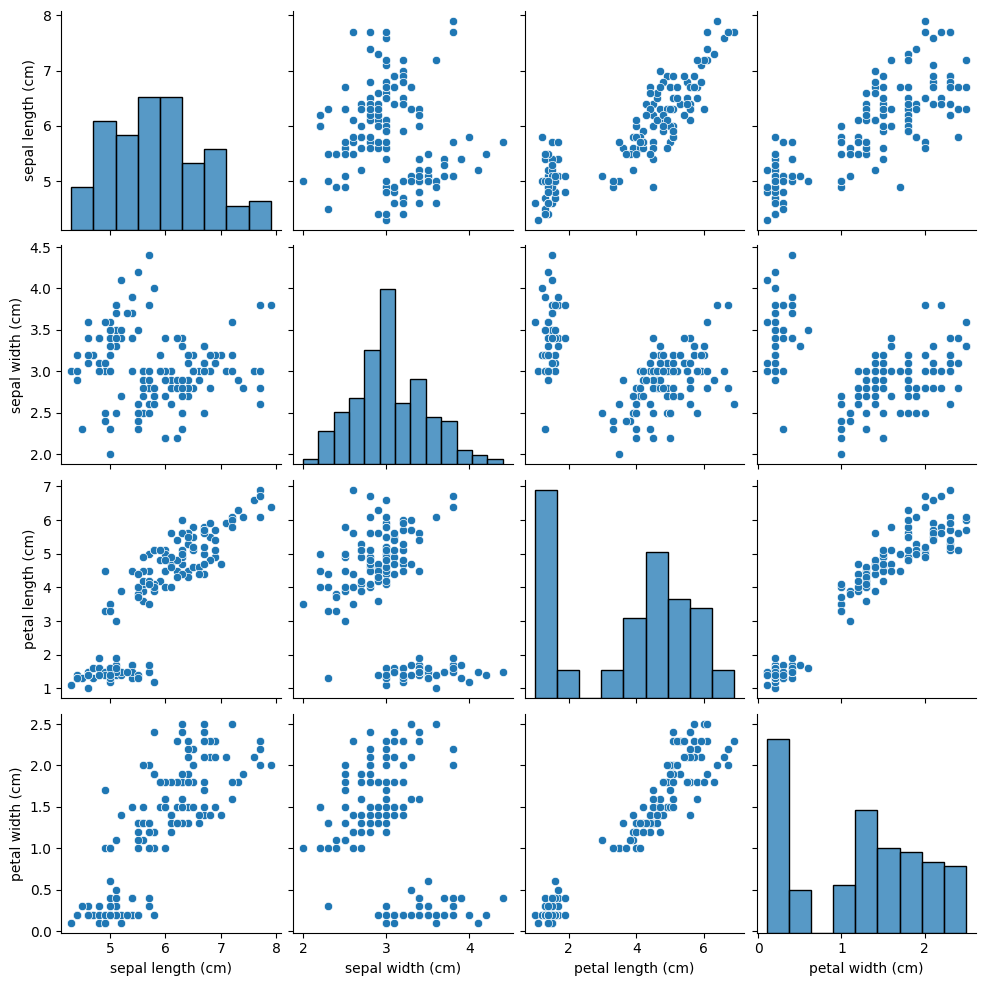

In [2]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [3]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data,
    iris_db.target,
    test_size=0.2,
    random_state=42 
    )

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

**1)** We again notice that the attributes are on different scales. We normalise, to standardize the scales of each attribute on both sets.

In [5]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  return (x-mu)/sigma


mu_train = torch.mean(x_train, dim=0)
sigma_train = torch.std(x_train, dim=0)

x_train_normalized = norm_set(x_train, mu_train, sigma_train)
x_test_normalized = norm_set(x_test, mu_train, sigma_train)

# add a feature for bias
x_train_normalized = torch.cat([x_train_normalized, torch.ones(x_train_normalized.shape[0], 1)], dim=1)
x_test_normalized = torch.cat([x_test_normalized, torch.ones(x_test_normalized.shape[0], 1)], dim=1)

x_test

tensor([[6.1000, 2.8000, 4.7000, 1.2000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [7.7000, 2.6000, 6.9000, 2.3000],
        [6.0000, 2.9000, 4.5000, 1.5000],
        [6.8000, 2.8000, 4.8000, 1.4000],
        [5.4000, 3.4000, 1.5000, 0.4000],
        [5.6000, 2.9000, 3.6000, 1.3000],
        [6.9000, 3.1000, 5.1000, 2.3000],
        [6.2000, 2.2000, 4.5000, 1.5000],
        [5.8000, 2.7000, 3.9000, 1.2000],
        [6.5000, 3.2000, 5.1000, 2.0000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [5.5000, 3.5000, 1.3000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.1000, 3.8000, 1.5000, 0.3000],
        [6.3000, 3.3000, 4.7000, 1.6000],
        [6.5000, 3.0000, 5.8000, 2.2000],
        [5.6000, 2.5000, 3.9000, 1.1000],
        [5.7000, 2.8000, 4.5000, 1.3000],
        [6.4000, 2.8000, 5.6000, 2.2000],
        [4.7000, 3.2000, 1.6000, 0.2000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [6.4000, 2.8000, 5.6000, 2

<Figure size 1400x600 with 0 Axes>

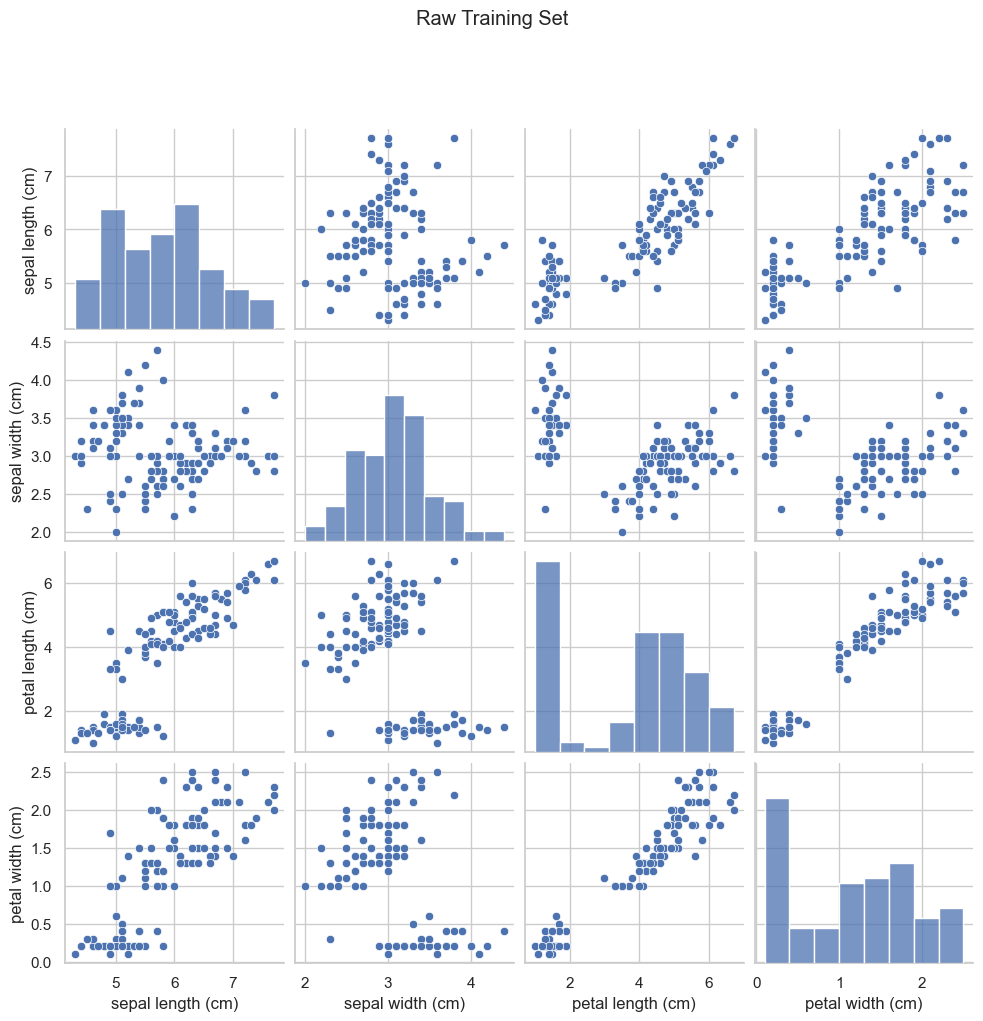

<Figure size 1400x600 with 0 Axes>

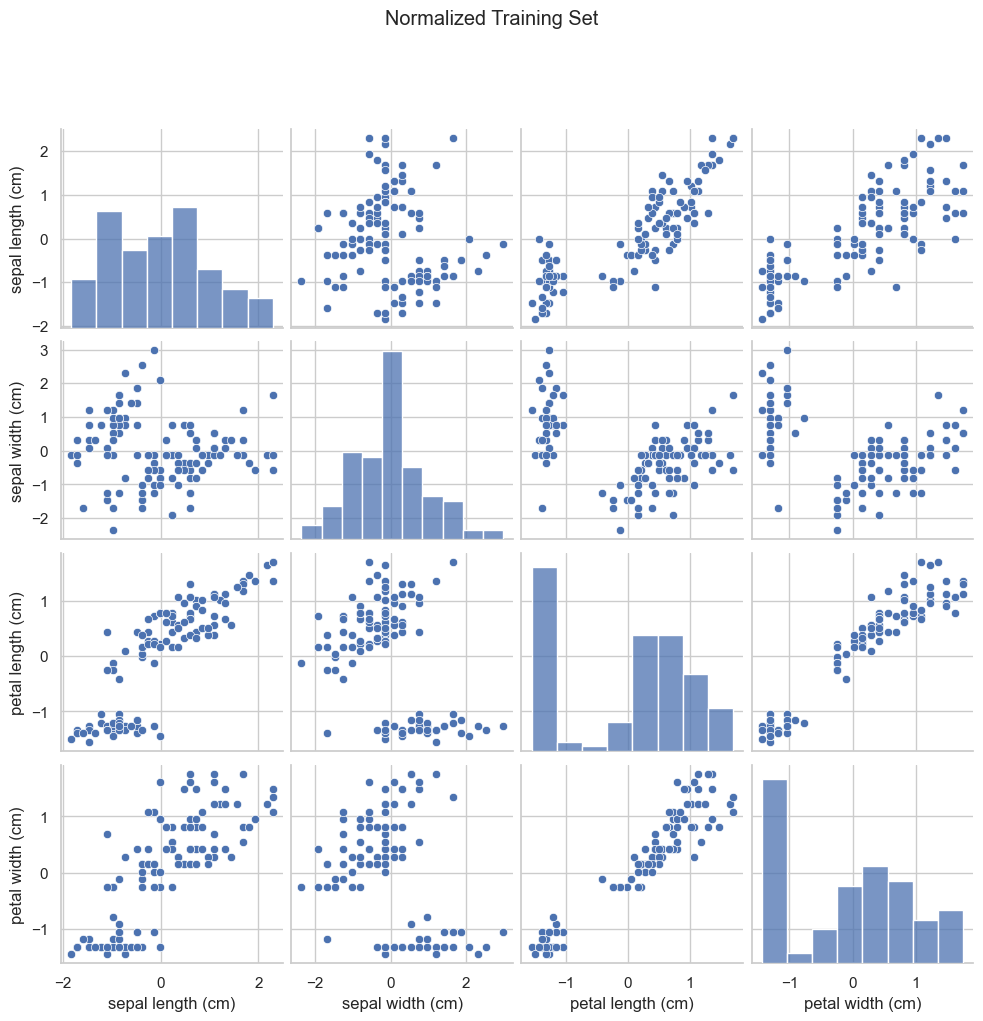

In [6]:
df_raw = pd.DataFrame(x_train.numpy(), columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
df_normalized = pd.DataFrame(x_train_normalized[:, :4].numpy(), columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
 
plt.figure(figsize=(14, 6))

# Plot raw data
sn.set(style='whitegrid')  
pairplot_raw = sn.pairplot(df_raw)
pairplot_raw.fig.suptitle("Raw Training Set", y=1.02)
plt.subplots_adjust(top=0.9)   
plt.show()

# Plot normalized data
plt.figure(figsize=(14, 6))
pairplot_normalized = sn.pairplot(df_normalized)
pairplot_normalized.fig.suptitle("Normalized Training Set", y=1.02)
plt.subplots_adjust(top=0.9)   
plt.show()


By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

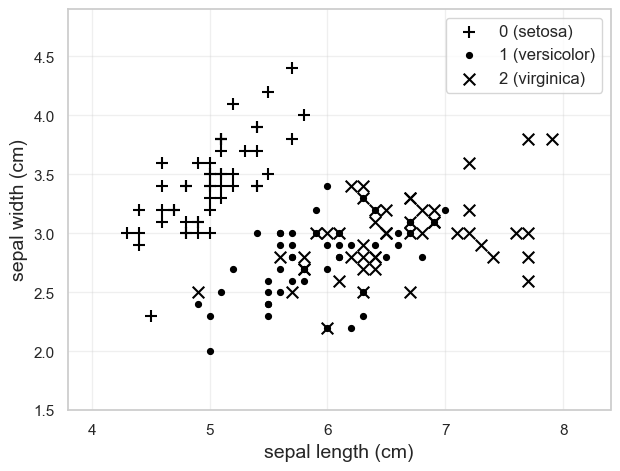

In [7]:
X = iris_db.data.iloc[:, :2]
Y = iris_db.target
marker_list = ['+', '.', 'x']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
  ax.scatter(
      X.loc[Y == l].iloc[:, 0],
      X.loc[Y == l].iloc[:, 1],
      marker=marker_list[l],
      s=70,
      color='black',
      label='{:d} ({:s})'.format(l, iris_db.target_names[l])
      )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?
 

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
train_set_1 = x_train_normalized[:, :2]
test_set_1 = x_test_normalized[:, :2]

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1)
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1)

setosa_train = (y_train == 0).int()
setosa_test = (y_test == 0).int()

## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

**Q2.** First implement the above function in `def sigmoid()`. [2 marks]

**Q3.** Then, using the implementation of `LinearRegression` from last week as guideline, create a custom pytorch layer for `LogisticRegression` [2 marks]

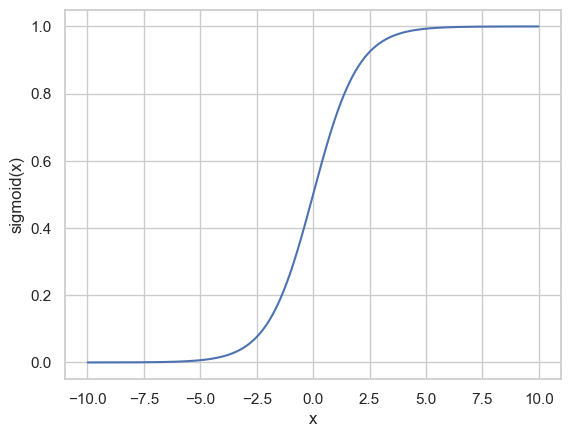

In [9]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  ### your code here
  z = (1+ torch.exp(-z))**(-1)
  return z

x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x): 
    y = sigmoid( torch.matmul(x,self.weight.T) )   
    print(f'y has shape: {y.shape}')
    
    return y

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m}  \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

**4)** We implement the cost in `bce()` and the `gradient_descent_step()` to update using the partial derivative above.

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:

  cost = -( y_true*torch.log(y_pred) + (1-y_true)*torch.log(1-y_pred) ).mean()  
  return cost

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  
  weight = model.weight
  N = X.shape[0] 
 
  w_der = (torch.sum( (y_pred-y) * X , dim=0))/N
  weight -= lr*w_der
  model.weight = nn.Parameter(weight, requires_grad=False)

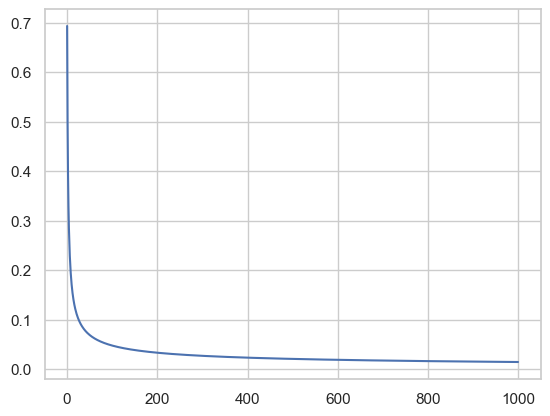

Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])
Minimum cost: 0.014265160076320171


In [12]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)  
    cost = bce(y_true=y , y_pred=prediction)
    cost_lst.append(cost)
    gradient_descent_step(model= model, X= x, y= y,y_pred= prediction, lr = alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 1
train(model, x= train_set_1, y= setosa_train, alpha= alpha)

**5)** Here we draw the decision boundary on the test set using the learned parameters.

Weight vector: Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])


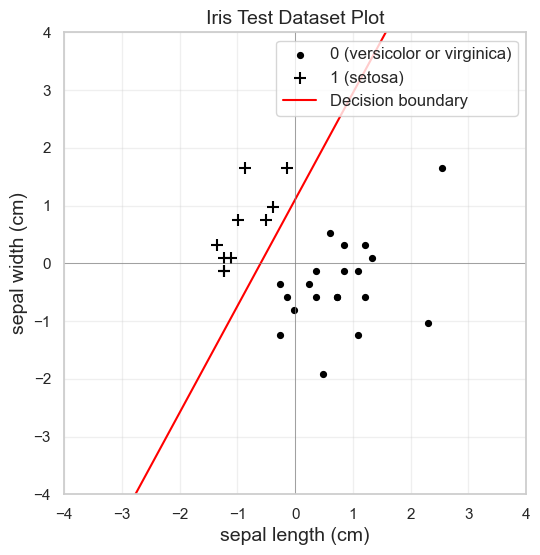

In [13]:
w0, w1, bias = model.weight[0]
x_vals = np.linspace(-4, 4, 200)

# Here we calculate corresponding y values for the decision line equation w0*x0 + w1*x1 + bias = 0
if w1 != 0:
    y_vals = -(w0 / w1) * x_vals - (bias / w1)
else:
    y_vals = np.full_like(x_vals, -bias / w0)


# Normalize the features separately for plotting
X0_norm = norm_set(torch.Tensor(X_test.iloc[:, 0].values).unsqueeze(1), mu_train[0], sigma_train[0])
X1_norm = norm_set(torch.Tensor(X_test.iloc[:, 1].values).unsqueeze(1), mu_train[1], sigma_train[1])
Y = setosa_test 

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

# Scatter plot for each class
for l in [0, 1]:
    ax.scatter(
        X0_norm[Y == l],
        X1_norm[Y == l],
        marker=marker_list[1-l],
        s=70,
        color='black',
        label='{:d} ({:s})'.format(l, ['versicolor or virginica', 'setosa'][l])
    )

 
ax.plot(x_vals, y_vals, label=r"Decision boundary", color="red")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.set_title("Iris Test Dataset Plot", fontsize=14)

ax.axhline(0, color="gray", linewidth=0.5)
ax.axvline(0, color="gray", linewidth=0.5)
ax.legend(fontsize=12, loc= 'upper right')
ax.grid(alpha=0.3)

print(f'Weight vector: {model.weight}')
plt.show()


Weight vector: Parameter containing:
tensor([[-7.6483,  4.1452, -4.5710]])


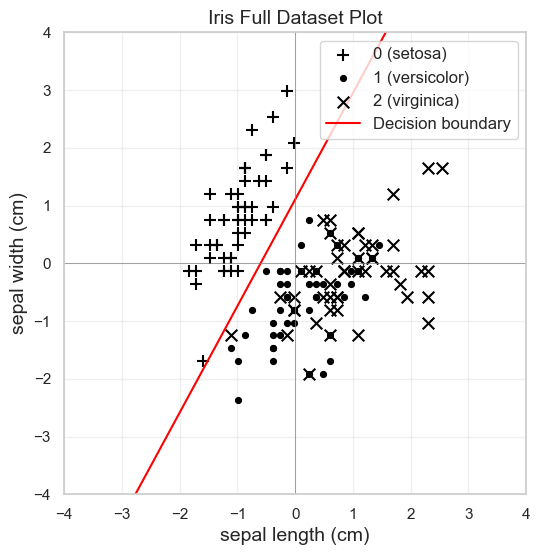

In [14]:
Y = iris_db.target

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_aspect('equal')

X0_norm = norm_set(torch.Tensor(X.iloc[:, 0].values).unsqueeze(1), mu_train[0], sigma_train[0])
X1_norm = norm_set(torch.Tensor(X.iloc[:, 1].values).unsqueeze(1), mu_train[1], sigma_train[1])
#scatter plot for each class
for l in [0, 1, 2]:
    ax.scatter(
        X0_norm[Y == l],
        X1_norm[Y == l],
        marker=marker_list[l],
        s=70,
        color='black',
        label='{:d} ({:s})'.format(l,iris_db.target_names[l])
    )

 
ax.plot(x_vals, y_vals, label=r"Decision boundary", color="red")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.set_title("Iris Full Dataset Plot", fontsize=14)

ax.axhline(0, color="gray", linewidth=0.5)
ax.axvline(0, color="gray", linewidth=0.5)
ax.legend(fontsize=12, loc= 'upper right')
ax.grid(alpha=0.3)

print(f'Weight vector: {model.weight}')
plt.show()


## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach. We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [15]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
print(y_test.shape)

torch.Size([30, 3])


In this section we will use the built in pytorch methods.


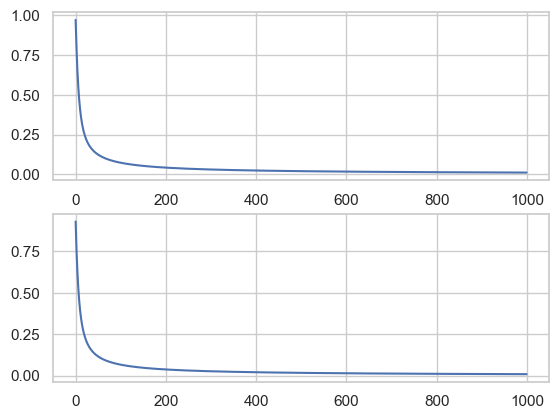

Minimum train cost: 0.011520283296704292
Minimum test cost: 0.009200941771268845


In [16]:
### your code here
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train_normalized.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
    
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))

train(setosa_model, x_train_normalized, setosa_labels, x_test_normalized, setosa_testy, optimiser, alpha)

Similar cost of the 4 attribute model compare to the previous one, therefore not overfitting.

**6)** Now we train classifiers for the other two classes.

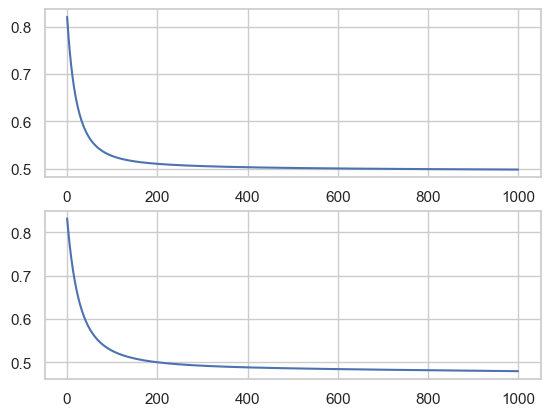

Minimum train cost: 0.4977635145187378
Minimum test cost: 0.4796465039253235


In [17]:
alpha = 0.1
versicolor_model = nn.Sequential(nn.Linear(x_train_normalized.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)

train(versicolor_model, x_train_normalized, versicolor_labels, x_test_normalized, versicolor_testy, optimiser, alpha) 

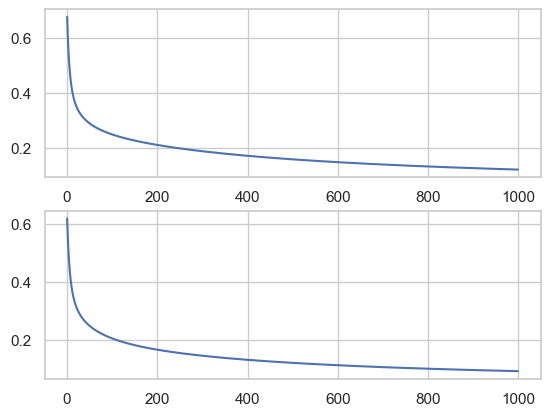

Minimum train cost: 0.12131591141223907
Minimum test cost: 0.0933215394616127


In [18]:
alpha = 0.13

virginica_model = nn.Sequential(nn.Linear(x_train_normalized.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)

train(virginica_model, x_train_normalized, virginica_labels, x_test_normalized, virginica_testy, optimiser, alpha) 
 

**7)** Using the 3 classifiers, we are going to predict the classes of the samples in the test set and show the predictions in a table.

In [19]:
setosa_pred = setosa_model(x_test_normalized)  
versicolor_pred = versicolor_model(x_test_normalized)   
virginica_pred = virginica_model(x_test_normalized)   
prbs = torch.cat([setosa_pred,versicolor_pred,virginica_pred], dim =1)
preds = prbs>0.5
 
test_tbl = pd.DataFrame(torch.cat([prbs, preds], dim =1).detach().numpy(), columns= ['setosa_prob', 'versicolor_prob', 'virginica_prob', 'setosa_pred', 'versicolor_pred', 'virginica_pred' ]) 
test_tbl[['setosa_pred', 'versicolor_pred', 'virginica_pred' ]] = test_tbl[['setosa_pred', 'versicolor_pred', 'virginica_pred' ]].astype(bool)
 
test_tbl

,setosa_prob,versicolor_prob,virginica_prob,setosa_pred,versicolor_pred,virginica_pred
0,0.010477,0.564324,0.112083,False,True,False
1,0.997012,0.050551,0.000012,True,False,False
2,0.000003,0.753696,0.997666,False,True,True
3,0.010417,0.388189,0.260900,False,False,False
4,0.002152,0.614063,0.253281,False,True,False
5,0.989276,0.129536,0.000023,True,False,False
6,0.076682,0.345271,0.041544,False,False,False
7,0.000452,0.214683,0.959666,False,False,True
8,0.000439,0.877918,0.429715,False,True,False
9,0.024968,0.570244,0.047410,False,True,False


Umbiguous areas are observed(i.e. Multiple classes for a single prediction) which is expected in the **1 vs all** approach.

**8)** We calculate the accuracy of the classifier on the test set, by comparing the predicted values against the ground truth and using a softmax for the classifier outputs.  

In [20]:
setosa_pred = setosa_model(x_test_normalized)  
versicolor_pred = versicolor_model(x_test_normalized)   
virginica_pred = virginica_model(x_test_normalized)   
prbs = torch.cat([setosa_pred,versicolor_pred,virginica_pred], dim =1)
prbs = F.softmax(prbs, dim=1)  

test_tbl = pd.DataFrame(torch.cat([prbs, y_test], dim =1).detach().numpy(), columns= ['setosa_prob', 'versicolor_prob', 'virginica_prob', 'setosa_value', 'versicolor_value', 'virginica_value' ]) 
 
test_tbl['predicted_class'] = test_tbl[['setosa_prob', 'versicolor_prob', 'virginica_prob']].idxmax(axis=1)
test_tbl['actual_class'] = test_tbl[['setosa_value', 'versicolor_value', 'virginica_value']].idxmax(axis=1)
 
label_map = {'setosa_prob': 0, 'versicolor_prob': 1, 'virginica_prob': 2}
label_map1 = {'setosa_value': 0, 'versicolor_value': 1, 'virginica_value': 2}

test_tbl['predicted_class'] = test_tbl['predicted_class'].map(label_map)
test_tbl['actual_class'] = test_tbl['actual_class'].map(label_map1)
test_tbl['correct_prediction'] = (test_tbl['actual_class'] == test_tbl['predicted_class'] ).astype(int)

test_tbl

,setosa_prob,versicolor_prob,virginica_prob,setosa_value,versicolor_value,virginica_value,predicted_class,actual_class,correct_prediction
0,0.259951,0.452297,0.287752,0.0,1.0,0.0,1,1,1
1,0.569120,0.220883,0.209997,1.0,0.0,0.0,0,0,1
2,0.171328,0.364043,0.464630,0.0,0.0,1.0,2,2,1
3,0.267117,0.389732,0.343151,0.0,1.0,0.0,1,1,1
4,0.242164,0.446539,0.311296,0.0,1.0,0.0,1,1,1
5,0.557064,0.235790,0.207147,1.0,0.0,0.0,0,0,1
6,0.305475,0.399597,0.294928,0.0,1.0,0.0,1,1,1
7,0.206247,0.255521,0.538232,0.0,0.0,1.0,2,2,1
8,0.202389,0.486712,0.310899,0.0,1.0,0.0,1,1,1
9,0.266825,0.460295,0.272880,0.0,1.0,0.0,1,1,1


In [21]:
setosa_pred_train = setosa_model(x_train_normalized)  
versicolor_pred_train = versicolor_model(x_train_normalized)   
virginica_pred_train = virginica_model(x_train_normalized)    
prbs_train = torch.cat([setosa_pred_train, versicolor_pred_train, virginica_pred_train], dim=1)
prbs_train = F.softmax(prbs_train, dim=1)
 
train_tbl = pd.DataFrame(torch.cat([prbs_train, y_train], dim=1).detach().numpy(), 
                         columns=['setosa_prob', 'versicolor_prob', 'virginica_prob', 'setosa_value', 'versicolor_value', 'virginica_value'])
 
train_tbl['predicted_class'] = train_tbl[['setosa_prob', 'versicolor_prob', 'virginica_prob']].idxmax(axis=1)
train_tbl['actual_class'] = train_tbl[['setosa_value', 'versicolor_value', 'virginica_value']].idxmax(axis=1)
 
train_tbl['predicted_class'] = train_tbl['predicted_class'].map(label_map)
train_tbl['actual_class'] = train_tbl['actual_class'].map(label_map1)
train_tbl['correct_prediction'] = (train_tbl['actual_class'] == train_tbl['predicted_class']).astype(int)

train_tbl


,setosa_prob,versicolor_prob,virginica_prob,setosa_value,versicolor_value,virginica_value,predicted_class,actual_class,correct_prediction
0,0.569517,0.220856,0.209627,1.0,0.0,0.0,0,0,1
1,0.575276,0.213035,0.211689,1.0,0.0,0.0,0,0,1
2,0.285087,0.395978,0.318935,0.0,1.0,0.0,1,1,1
3,0.560561,0.232566,0.206872,1.0,0.0,0.0,0,0,1
4,0.554433,0.240989,0.204578,1.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...
115,0.270867,0.442850,0.286282,0.0,1.0,0.0,1,1,1
116,0.221921,0.370743,0.407337,0.0,0.0,1.0,2,2,1
117,0.572459,0.216805,0.210736,1.0,0.0,0.0,0,0,1
118,0.253892,0.480550,0.265558,0.0,1.0,0.0,1,1,1


In [22]:
print (f'The accuracy score of the classifier on the test set by applying the softmax function on the outputs of the model is {test_tbl["correct_prediction"].mean()}\n')
print (f'The accuracy score of the classifier on the training set by applying the softmax function on the outputs of the model is {train_tbl["correct_prediction"].mean()}\n')

The accuracy score of the classifier on the test set by applying the softmax function on the outputs of the model is 0.9666666666666667

The accuracy score of the classifier on the training set by applying the softmax function on the outputs of the model is 0.9333333333333333



### We expect the results not have an accuracy of 100% as our dataset is not entirely linearly seperable.

## 3. The XOR problem
(Motivation for Neural Networks)

**9)** Looking at the datapoints below, can we draw a decision boundary using Logistic Regression? Why? What are the specific issues or logistic regression with regards to XOR? 

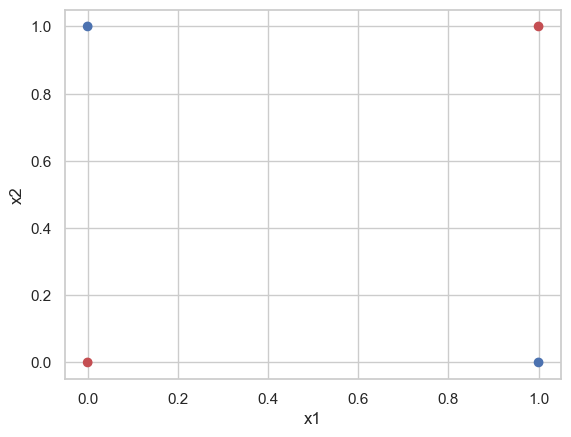

In [23]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()